In [1]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sionna.rt as rt
import numpy as np

In [2]:
from sionna.rt import Scene, RadioMaterial, HolderMaterial, PlanarArray, Transmitter

N = 100
vert_x, vert_y = np.meshgrid(
    np.linspace(0, 10, N),
    np.linspace(0, 10, N),
    indexing="xy")
vert_z = (np.sin(2 * vert_x) + np.sin(2 * vert_y)) / 2
vert_xyz = np.stack([vert_x, vert_y, vert_z], axis=2).reshape(-1, 3)

# Triangulate
vertex_indices = np.arange(N * N)
is_last_column = (vertex_indices + 1) % N == 0
is_last_row = vertex_indices // N == N - 1
ii = vertex_indices[~is_last_row & ~is_last_column]
faces = np.stack([[ii, ii + 1, ii + N + 1], [ii, ii + N + 1, ii + N]])
faces = np.concatenate(faces.T, axis=-1).T

# Create scene
props = mi.Properties()
props["material"] = RadioMaterial("mat", thickness=0.01)
# Sionna requires bsdfs to be wrapped in HolderMaterial
props["material"] = HolderMaterial(props)
mi_mesh = mi.Mesh(name="terrain",
                    vertex_count=vert_xyz.shape[0],
                    face_count=faces.shape[0], 
                    props=props)
mi_mesh_params = mi.traverse(mi_mesh)
mi_mesh_params["vertex_positions"] = mi.Float(vert_xyz.ravel().astype(np.float32))
mi_mesh_params["faces"] = mi.UInt(faces.ravel().astype(np.uint32))
mi_mesh_params.update()
mi_scene = mi.load_dict({
    "type": "scene",
    "terrain": mi_mesh
})
scene = Scene(mi_scene)
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")
tx = Transmitter(name="tx",
                 position=mi.Point3f(0, 0, 1),
                 orientation=mi.Point3f(0,0,0),
                 power_dbm=100)
scene.add(tx)

In [3]:
meas_surf = mi.Mesh(name="terrain",
                    vertex_count=vert_xyz.shape[0],
                    face_count=faces.shape[0], 
                    props=props)
meas_surf_params = mi.traverse(meas_surf)
vert_xyz_ms = vert_xyz + np.array([0, 0, 0.001])
meas_surf_params["vertex_positions"] = mi.Float(vert_xyz_ms.ravel().astype(np.float32))
meas_surf_params["faces"] = mi.UInt(faces.ravel().astype(np.uint32))
meas_surf_params.update();

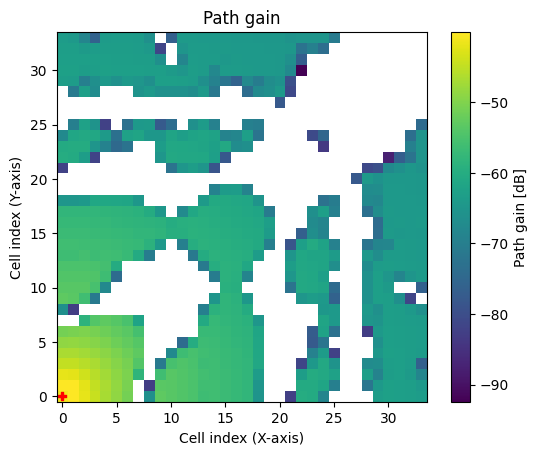

In [49]:
rm_solver = rt.RadioMapSolver()
rm = rm_solver(scene=scene, 
               meas_surf=meas_surf, 
               cell_size=[0.3, 0.3],
               samples_per_tx=int(1e7),
               diffuse_reflection=False,
               max_depth=5)
rm.show();

In [ ]:
from tqdm import tqdm

front_cam = rt.Camera(position=[-10, 0, 8], look_at=[3, 5, 0])
back_cam = rt.Camera(position=[2, 20, 9], look_at=[5, 5, 0])
data = {"front": [], "back": [], "rm": []}
spp = 128
max_depths = [0, 1, 3, 5]
for max_depth in tqdm(max_depths):
    rm = rm_solver(scene=scene, 
                   meas_surf=meas_surf, 
                   cell_size=[0.3, 0.3],
                   samples_per_tx=int(1e7),
                   diffuse_reflection=True,
                   max_depth=max_depth)
    data["rm"].append(rm)
    img = scene.render(camera=front_cam, radio_map=rm, return_bitmap=True, num_samples=spp)
    data["front"].append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))
    img = scene.render(camera=back_cam, radio_map=rm, return_bitmap=True, num_samples=spp)
    data["back"].append(img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True))

  0%|          | 0/4 [00:00<?, ?it/s]/Users/jason/miniforge3/envs/sionna-rt/lib/python3.13/site-packages/drjit/ast.py:838: RuntimeWarning: The AST-transforming decorator @drjit.syntax was called more than 1000 times by your program. Since transforming and recompiling Python code is a relatively expensive operation, it should not be used within loops or subroutines. Please move the function to be transformed to the top program level and decorate it there.
  warnings.warn(
100%|██████████| 4/4 [01:09<00:00, 17.42s/it]


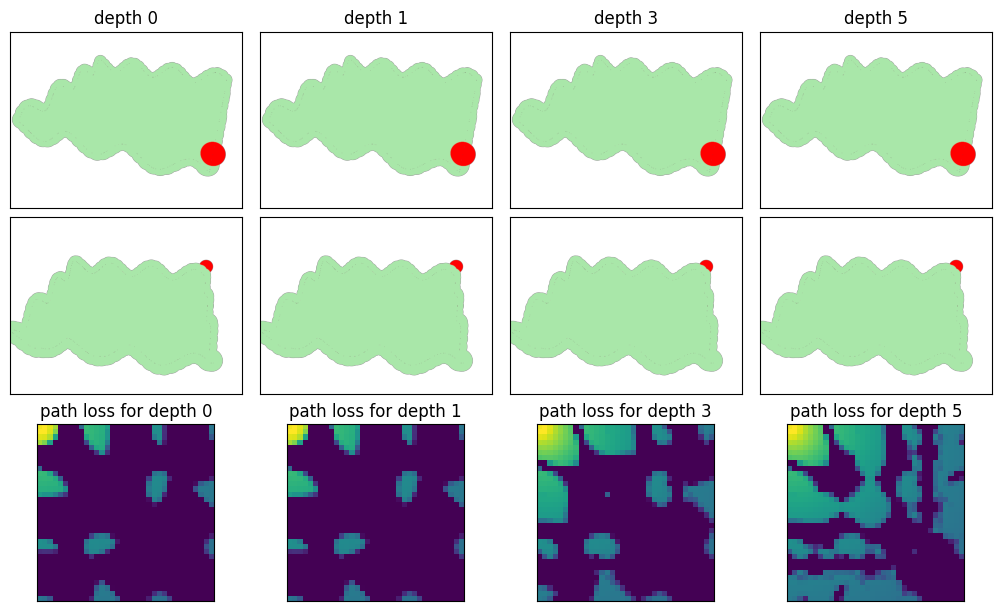

In [196]:
fig, axs = plt.subplots(3, 4, constrained_layout=True)
fig.set_size_inches(10, 6)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
norm = mpl.colors.Normalize(
    np.min([10 * np.log10(np.maximum(1e-8, rm.path_gain)) for rm in data["rm"]]),
    np.max([10 * np.log10(np.maximum(1e-8, rm.path_gain)) for rm in data["rm"]]))
for j in range(4):
    for i, key in enumerate(["front", "back"]):
        axs[i, j].imshow(data[key][j])
    path_gain = np.squeeze(data["rm"][j].path_gain)
    axs[2, j].imshow(10 * np.log10(np.maximum(1e-8, path_gain)), norm=norm)

for k in range(4):
    axs[0, k].set_title(f"depth {max_depths[k]}")
    axs[2, k].set_title(f"path loss for depth {max_depths[k]}")

In [36]:
np.max(img)

np.float32(1.2430193)

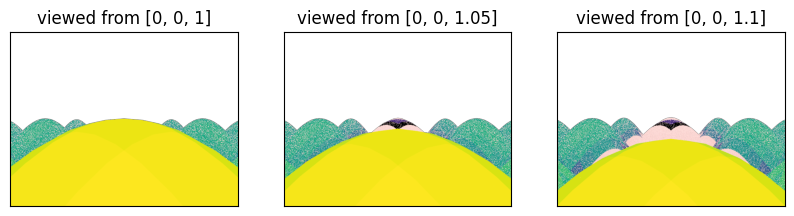

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(10, 4)

def render_from(position, spp=16):
    cam = rt.Camera(position=position, look_at=[5, 5, 1])
    img = scene.render(camera=cam, 
                       radio_map=data["rm"][0], 
                       show_devices=False,
                       return_bitmap=True,
                       num_samples=spp);
    return img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True)

for i, pos in enumerate([[0, 0, 1], [0, 0, 1.05], [0, 0, 1.1]]):
    axs[i].imshow(render_from(pos))
    axs[i].set(xticks=[], yticks=[])
    axs[i].set_title(f"viewed from {pos}")

In [127]:
def paths_to_coverage_map(paths):
    """
    Converts paths into the equivalent coverage map values.
    The coverage map is assumed to be a square.
    """
    # [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
    a_real, a_imag = paths.a
    a = a_real.numpy() + 1j*a_imag.numpy()

    # Transmit precoding
    # Assume default precoding
    # [num_rx, num_rx_ant, num_tx, num_paths]
    a /= np.sqrt(a.shape[3])
    a = np.sum(a, axis=3)

    # Sum energy of paths
    a = np.square(np.abs(a))
    # [num_rx, num_tx]
    a = np.sum(a, axis=(1, 3))

    # Swap dims
    # [num_tx, num_rx]
    a = a.T

    # Reshape to coverage map
    n = int(np.sqrt(a.shape[1]))
    shape = [a.shape[0], n, n]
    a = np.reshape(a, shape)

    return a

In [ ]:
# only run this once!
cell_centers = data["rm"][0].cell_centers.numpy()
cell_centers = np.reshape(cell_centers, [-1,3])
for i, pos in enumerate(cell_centers):
    scene.add(rt.Receiver(name=f"rx-{i}",
                        position=mi.Point3f(pos),
                        orientation=mi.Point3f(0., 0., 0.)))
scene.rx_array =  PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="iso",
                              polarization="VH")

In [ ]:
solver = rt.PathSolver()
paths = solver(scene=scene,
               samples_per_src=int(1e6),
               max_num_paths_per_src=int(1e7),
               max_depth=1,
               los=True,
               specular_reflection=True,
               diffuse_reflection=True,
               refraction=True)
rm_ref_raw = paths_to_coverage_map(paths)

/Users/jason/miniforge3/envs/sionna-rt/lib/python3.13/site-packages/drjit/ast.py:838: RuntimeWarning: The AST-transforming decorator @drjit.syntax was called more than 1000 times by your program. Since transforming and recompiling Python code is a relatively expensive operation, it should not be used within loops or subroutines. Please move the function to be transformed to the top program level and decorate it there.
  warnings.warn(


/var/folders/dp/9xqdy2vn535883dxlm82nwtc0000gn/T/ipykernel_34727/1643289085.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10(rm_ref.path_gain.numpy().squeeze()))


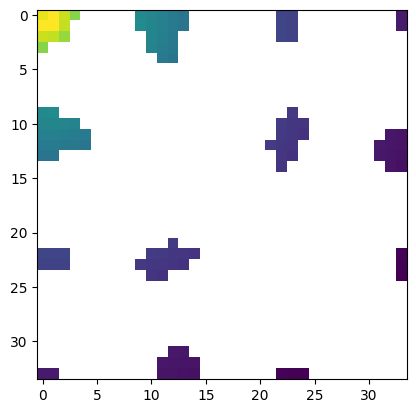

In [ ]:
rm_ref = rt.RadioMap(scene=scene, 
                     meas_surf=meas_surf, 
                     cell_size=[0.3, 0.3])
# fake a RadioMap object by updating the backing array with values from the multi-receiver method
dr.scatter(rm_ref._pathgain_map.array, np.ravel(rm_ref_raw), np.arange(np.prod(rm_ref_raw.shape)))
plt.imshow(10 * np.log10(rm_ref.path_gain.numpy().squeeze()))
# plt.imshow(rm_true._pathgain_map.numpy().squeeze())
# scene.preview(radio_map=rm_true, show_devices=False)

In [141]:
def paths_to_radio_map(paths):
    rm_raw = paths_to_coverage_map(paths)
    rm = rt.RadioMap(scene=scene, 
                     meas_surf=meas_surf, 
                     cell_size=[0.3, 0.3])
    # fake a RadioMap object by updating the backing array with values from the multi-receiver method
    dr.scatter(rm._pathgain_map.array, np.ravel(rm_raw), np.arange(np.prod(rm_raw.shape)))
    return rm

In [216]:
from time import perf_counter

max_depths = np.arange(6)
res: dict[str, list[rt.RadioMap]] = {"shoot_and_bounce": [], "antenna_pairs": []}
rm_solver = rt.RadioMapSolver()

# for some reason drjit implodes if I try to wrap this in a python for loop
def block(max_depth):
    path_solver = rt.PathSolver()
    paths = path_solver(
        scene=scene,
        max_depth=max_depth,
        max_num_paths_per_src=int(4e6),
        samples_per_src=int(4e6),
        synthetic_array=True,
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=True,
    )
    res["antenna_pairs"].append(paths_to_radio_map(paths))

max_depth = 0
while max_depth <= 5:
    print(f"Running with depth = {max_depth}")
    start = perf_counter()
    block(max_depth)
    stop = perf_counter()
    print(f"Finished antenna pairs method. Took {stop - start} seconds.")

    start = perf_counter()
    rm = rm_solver(
        scene=scene, 
        meas_surf=meas_surf, 
        cell_size=[0.3, 0.3],
        proj_normal=[0, 0, 1],
        samples_per_tx=int(1e7),
        max_depth=max_depth,
        los=True,
        diffuse_reflection=True,
        refraction=True,
    )
    res["shoot_and_bounce"].append(rm)
    stop = perf_counter()
    print(f"Finished shoot and bounce method. Took {stop - start} seconds.")

    max_depth += 1

Running with depth = 0


/Users/jason/miniforge3/envs/sionna-rt/lib/python3.13/site-packages/drjit/ast.py:838: RuntimeWarning: The AST-transforming decorator @drjit.syntax was called more than 1000 times by your program. Since transforming and recompiling Python code is a relatively expensive operation, it should not be used within loops or subroutines. Please move the function to be transformed to the top program level and decorate it there.
  warnings.warn(


Finished antenna pairs method. Took 0.8225305419764481 seconds.
Finished shoot and bounce method. Took 0.277591707999818 seconds.
Running with depth = 1
Finished antenna pairs method. Took 23.33709804096725 seconds.
Finished shoot and bounce method. Took 0.12844474997837096 seconds.
Running with depth = 2
Finished antenna pairs method. Took 33.444180624966975 seconds.
Finished shoot and bounce method. Took 0.24606479197973385 seconds.
Running with depth = 3
Finished antenna pairs method. Took 41.36525650002295 seconds.
Finished shoot and bounce method. Took 0.14066741697024554 seconds.
Running with depth = 4
Finished antenna pairs method. Took 45.16325704200426 seconds.
Finished shoot and bounce method. Took 0.2500108330277726 seconds.
Running with depth = 5
Finished antenna pairs method. Took 48.815018416033126 seconds.
Finished shoot and bounce method. Took 0.15457554097520187 seconds.


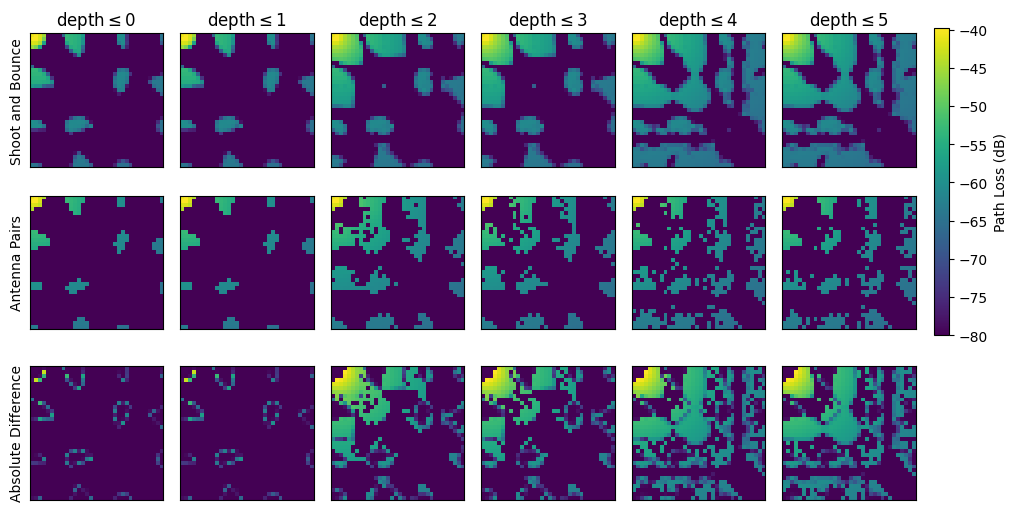

In [221]:
def path_gain_to_db(path_gain):
    path_gain = np.maximum(np.squeeze(np.array(path_gain)), 1e-8)
    return 10 * np.log10(path_gain)

fig, axs = plt.subplots(ncols=len(max_depths), nrows=3, constrained_layout=True)
fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.1, wspace=0.1)
fig.set_size_inches(10, 5)
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])
rms = path_gain_to_db([rm.path_gain for rm in res["shoot_and_bounce"]])
rms_ref = path_gain_to_db([rm.path_gain for rm in res["antenna_pairs"]])
norm = mpl.colors.Normalize(np.min([rms, rms_ref]), np.max([rms, rms_ref]))
diff = np.abs(rms - rms_ref)
norm_diff = mpl.colors.Normalize(np.min(diff), np.max(diff))
for i, max_depth in enumerate(max_depths):
    axs[0, i].imshow(rms[i], norm=norm)
    axs[1, i].imshow(rms_ref[i], norm=norm)
    axs[2, i].imshow(diff[i], norm=norm_diff)
    axs[0, i].set_title(f"$\\text{{depth}} \\leq {max_depth}$")
axs[0, 0].set_ylabel("Shoot and Bounce")
axs[1, 0].set_ylabel("Antenna Pairs")
axs[2, 0].set_ylabel("Absolute Difference")
plt.colorbar(mpl.cm.ScalarMappable(norm), ax=axs[0:2, :], pad=0.02, label="Path Loss (dB)")

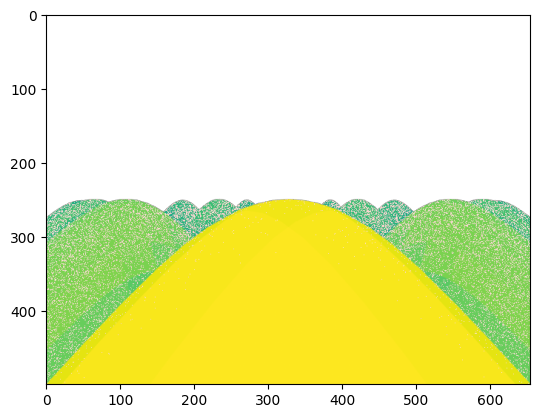

In [210]:
def render_from(position, radio_map, spp=16):
    cam = rt.Camera(position=position, look_at=[5, 5, 1])
    img = scene.render(camera=cam, 
                       radio_map=radio_map, 
                       show_devices=False,
                       return_bitmap=True,
                       fov=90,
                       num_samples=spp);
    return img.convert(mi.Bitmap.PixelFormat.RGBA, mi.Struct.Type.UInt8, True)

plt.imshow(render_from([0, 0, 1], radio_map=res["shoot_and_bounce"][5]))

In [213]:
# scene.preview(radio_map=res["antenna_pairs"][5], show_devices=False)
scene.preview(radio_map=res["shoot_and_bounce"][5], show_devices=False)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…